# Quantitative Trading Strategy # 1

## Futures Spread Dynamics : Gold Miners ETF series

## Sections
1. Objectives
2. Preliminaries
3. Data Imports and Cleaning
4. Trading Strategies
5. Comparing with Fama-French style factors
6. Conclusion

## 1. Objectives

This is a demonstration of building a quantitative trading strategy based on the return spreads of two highly correlated time series. Here, the series used are two Gold Miner ETFs namely:
<b><br>
- iShares MSCI Global Gold Miners ETF (NASDAQ Ticker: RING) <br>
- VanEck Gold Miners ETF (NASDAQ Ticker: GDX)
</b>
Since the daily returns on these series are highly correlated (Correlation of 96.4% from December 2019 to December 2021), we expect that any difference in returns of the two series should mean revert over a period of time. At the same time, one series (RING) is far more liquid than the other series(GDX) and we do observe some deviations in returns at a daily level.

The objective of this analysis is to build a trading algorithm that executes Sell Spread trades if the return spread is positive and Buy Spread trades if the return spread is negative and analyze the return performance. Subsequently, we try to find the best parameters to use for such a strategy and the correlation of such a strategy's returns with Fama-French style factors.
    
Some of the variables that could be subsequently analyzed are:

<b>1. M (Days):</b> Window size for computing the average of daily returns. As the returns on any given day could be volatile, we would take M Day rolling window to allow smoothening of the spread<br>
<b>2. g (Strategy Entering Spread): </b>If the M days average return spread exceeds g, we should enter the strategy<br>
<b>3. j (Strategy Exit Spread):</b> Once the strategy is live, if the M days spread comes below j, we should exit the strategy<br>
<b>4. s (Stop Loss Threshold):</b> If the strategy losses this proportion of amount relative to the Gross Cash value of strategy, the strategy is pre-maturly exited, the losses are liquidated and we do not trade for the remainder of the month<br>

We play with M, g, j and s to see how our strategy performs under different scenarios.

<b> Assumptions: </b><br>
    1. We can buy or sell at the EoD price <br>
    2. Do not put any constraint on capital <br>
    3. No shorting costs considered<br>

## 2. Preliminaries
This section includes the import of relevant libraries and defining the functions for executing, plotting and analyzing the spread reverting trading strategies

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [15,8]

import numpy as np
import pandas as pd
import pandas_datareader as pdr
pd.options.display.float_format = '{:,.4f}'.format

import nasdaqdatalink

import seaborn as sns
sns.color_palette("mako", as_cmap=True)

import warnings
warnings.filterwarnings('ignore')

In [2]:
def executeStrategy(M,g,j,s,plot=True,ylim = None):
    '''
    For the given Rolling Window size and enter and exit thresholds, execute the strategy every day for years2020 and 2021
    Optionally, plots the strategy returns by calling the function 'plotStrategy'
    '''    
    data = df.copy()    
    data['RollRetRING_GDX'] = data['RINGminusGDXRet'].rolling(M).mean()    
    data['action'] = 0
    data['sharesRING'] = 0
    data['sharesGDX'] = 0
    data['positionValue'] = 0
    data['dayPnL'] = 0
    data['positionPnL'] = 0
    data['cumPnL'] = 0
    data['grossCash'] = 0
    
    buySpread = []
    sellSpread = []  
    stopLoss = []
    monthEnd = []
    
    for y in ['2020-','2021-']:
        for m in range(1,13):
            period = y+str(m)

            #first day of the trading month
            first = data.loc[period].iloc[0].name
            
            data.loc[first,'cumPnL'] = data.iloc[data.index.get_loc(first)-1]['cumPnL']
            
            if data.loc[first,'RollRetRING_GDX'] > g:
                data.loc[first,'action'] = -1
                sellSpread.append(first)
                
            elif data.loc[first,'RollRetRING_GDX'] < -g:
                data.loc[first,'action'] = 1
                buySpread.append(first)

            if data.loc[first,'action'] != 0:            
                volume = data.loc[first,'Nt']/100            
                data.loc[first,'sharesRING'] = data.loc[first,'action']\
                                                    *round(volume/data.loc[first,'RINGadj_close'],0)            
                data.loc[first,'sharesGDX'] = -data.loc[first,'action']\
                                                    *round(volume/data.loc[first,'GDXadj_close'],0)            
                
                data.loc[first,'positionValue'] = data.loc[first,'sharesRING'] * data.loc[first,'RINGadj_close'] \
                                             + data.loc[first,'sharesGDX'] * data.loc[first,'GDXadj_close']
                
                data.loc[first,'grossCash'] = abs(data.loc[first,'sharesRING'] * data.loc[first,'RINGadj_close']) \
                                             + abs(data.loc[first,'sharesGDX'] * data.loc[first,'GDXadj_close'])
                
                #Note: dayPnL and positionPnL do not change on the day of entring position

            #second to second last day of the trading month
            for i, row in data.loc[period].iloc[1:-1].iterrows():           

                #No outstanding position case
                if data.iloc[data.index.get_loc(i)-1]['action'] == 0:

                    if data.loc[i,'RollRetRING_GDX'] > g:                    
                        data.loc[i,'action'] = -1
                        sellSpread.append(i)

                    elif data.loc[i,'RollRetRING_GDX'] < -g:
                        data.loc[i,'action'] = 1 
                        buySpread.append(i)
                    else:
                        data.loc[i,'cumPnL'] = data.iloc[data.index.get_loc(i)-1]['cumPnL']
                        continue

                    volume = data.loc[i,'Nt']/100
                    data.loc[i,'sharesRING'] = data.loc[i,'action']\
                                                        *round(volume/data.loc[i,'RINGadj_close'],0) 

                    data.loc[i,'sharesGDX'] = -data.loc[i,'action']\
                                                        *round(volume/data.loc[i,'GDXadj_close'],0) 
                    
                    data.loc[i,'positionValue'] = data.loc[i,'sharesRING'] * data.loc[i,'RINGadj_close'] \
                                                 + data.loc[i,'sharesGDX'] * data.loc[i,'GDXadj_close']

                    data.loc[i,'grossCash'] = abs(data.loc[i,'sharesRING'] * data.loc[i,'RINGadj_close']) \
                                                 + abs(data.loc[i,'sharesGDX'] * data.loc[i,'GDXadj_close'])        

                    data.loc[i,'cumPnL'] = data.iloc[data.index.get_loc(i)-1]['cumPnL']                

                    #Note: dayPnL and positionPnL do not change on the day of entring position                


                #Outstanding short Y long X case
                elif data.iloc[data.index.get_loc(i)-1]['action'] == -1:                

                    #As possible trading only at closing price, PositionValue and DailyPnLbased on yesterday's holding                    
                    data.loc[i,'positionValue'] = data.iloc[data.index.get_loc(i)-1]['sharesRING']*data.loc[i,'RINGadj_close']\
                                                + data.iloc[data.index.get_loc(i)-1]['sharesGDX']*data.loc[i,'GDXadj_close']
                    data.loc[i,'dayPnL'] = data.loc[i,'positionValue'] - data.iloc[data.index.get_loc(i)-1]['positionValue']

                    #will not change even if the position reverses or gets closed
                    data.loc[i,'cumPnL'] = data.iloc[data.index.get_loc(i)-1]['cumPnL'] + data.loc[i,'dayPnL']


                    #will go to zero if the position closes or gets reversed
                    data.loc[i,'positionPnL'] = data.iloc[data.index.get_loc(i)-1]['positionPnL'] + data.loc[i,'dayPnL']

                    #Keeping the same gross cash. This may be over-written if change in position on this day
                    data.loc[i,'grossCash'] = data.iloc[data.index.get_loc(i)-1]['grossCash']          

                    #Stop Loss case
                    if data.loc[i,'positionPnL']/data.loc[i,'grossCash'] < s:                    
                        data.loc[i,'action'] = 0
                        data.loc[i,'sharesRING'] = 0
                        data.loc[i,'sharesGDX'] = 0
                        data.loc[i,'grossCash'] = 0
                        data.loc[i,'positionPnL'] = 0
                        data.loc[i:,'cumPnL'] = data.loc[i,'cumPnL']
                        data.loc[i,'positionValue'] = data.loc[i,'sharesRING']*data.loc[i,'RINGadj_close']\
                                                + data.loc[i,'sharesGDX']*data.loc[i,'GDXadj_close']
                        stopLoss.append(i)
                        break

                    #Reverse position case
                    elif data.loc[i,'RollRetRING_GDX'] < -g:                    
                        data.loc[i]['action'] = 1                    
                        volume = data.loc[i,'Nt']/100
                        data.loc[i,'sharesRING'] = data.loc[i,'action']*round(volume/data.loc[i,'RINGadj_close'],0)
                        data.loc[i,'sharesGDX'] = -data.loc[i,'action']*round(volume/data.loc[i,'GDXadj_close'],0)
                        data.loc[i,'grossCash'] = abs(data.loc[i,'sharesRING'] * data.loc[i,'RINGadj_close']) \
                                                + abs(data.loc[i,'sharesGDX'] * data.loc[i,'GDXadj_close'])                    
                        data.loc[i,'positionPnL'] = 0
                        data.loc[i,'positionValue'] = data.loc[i,'sharesRING']*data.loc[i,'RINGadj_close']\
                                                + data.loc[i,'sharesGDX']*data.loc[i,'GDXadj_close']                        
                        buySpread.append(i)

                    #close the position case
                    elif data.loc[i,'RollRetRING_GDX'] < j:                    
                        data.loc[i,'action'] = 0
                        data.loc[i,'sharesRING'] = 0
                        data.loc[i,'sharesGDX'] = 0
                        data.loc[i,'grossCash'] = 0
                        data.loc[i,'positionPnL'] = 0
                        data.loc[i,'positionValue'] = data.loc[i,'sharesRING']*data.loc[i,'RINGadj_close']\
                                                + data.loc[i,'sharesGDX']*data.loc[i,'GDXadj_close']                        
                        buySpread.append(i)

                    #continue with the open position
                    else:
                        data.loc[i,'action'] = data.iloc[data.index.get_loc(i)-1]['action']
                        data.loc[i,'sharesRING'] = data.iloc[data.index.get_loc(i)-1]['sharesRING']
                        data.loc[i,'sharesGDX'] = data.iloc[data.index.get_loc(i)-1]['sharesGDX']

                #Outstanding short X long Y case
                elif data.iloc[data.index.get_loc(i)-1]['action'] == 1:                

                    #As possible trading only at closing price, PositionValue and DailyPnLbased on yesterday's holding                    
                    data.loc[i,'positionValue'] = data.iloc[data.index.get_loc(i)-1]['sharesRING']*data.loc[i,'RINGadj_close']\
                                                + data.iloc[data.index.get_loc(i)-1]['sharesGDX']*data.loc[i,'GDXadj_close']
                    data.loc[i,'dayPnL'] = data.loc[i,'positionValue'] - data.iloc[data.index.get_loc(i)-1]['positionValue']

                    #will not change even if the position reverses or gets closed
                    data.loc[i,'cumPnL'] = data.iloc[data.index.get_loc(i)-1]['cumPnL'] + data.loc[i,'dayPnL']


                    #will go to zero if the position closes or gets reversed
                    data.loc[i,'positionPnL'] = data.iloc[data.index.get_loc(i)-1]['positionPnL'] + data.loc[i,'dayPnL']

                    #Keeping the same gross cash. This may be over-written if change in position on this day
                    data.loc[i,'grossCash'] = data.iloc[data.index.get_loc(i)-1]['grossCash']

                    #Stop Loss case
                    if data.loc[i,'positionPnL']/data.loc[i,'grossCash'] < s:

                        data.loc[i,'action'] = 0
                        data.loc[i,'sharesRING'] = 0
                        data.loc[i,'sharesGDX'] = 0
                        data.loc[i,'grossCash'] = 0
                        data.loc[i,'positionPnL'] = 0
                        data.loc[i:,'cumPnL'] = data.loc[i,'cumPnL']
                        data.loc[i,'positionValue'] = data.loc[i,'sharesRING']*data.loc[i,'RINGadj_close']\
                                                + data.loc[i,'sharesGDX']*data.loc[i,'GDXadj_close']
                        stopLoss.append(i)
                        break

                    #Reverse position case
                    elif data.loc[i,'RollRetRING_GDX'] > g:

                        data.loc[i]['action'] = -1
                        volume = data.loc[i,'Nt']/100
                        data.loc[i,'sharesRING'] = data.loc[i,'action']*round(volume/data.loc[i,'RINGadj_close'],0)
                        data.loc[i,'sharesGDX'] = -data.loc[i,'action']*round(volume/data.loc[i,'GDXadj_close'],0)
                        data.loc[i,'grossCash'] = abs(data.loc[i,'sharesRING'] * data.loc[i,'RINGadj_close']) \
                                                + abs(data.loc[i,'sharesGDX'] * data.loc[i,'GDXadj_close'])

                        data.loc[i,'positionPnL'] = 0
                        data.loc[i,'positionValue'] = data.loc[i,'sharesRING']*data.loc[i,'RINGadj_close']\
                                                + data.loc[i,'sharesGDX']*data.loc[i,'GDXadj_close']                        
                        sellSpread.append(i)

                    #close the position case
                    elif data.loc[i,'RollRetRING_GDX'] > j:

                        data.loc[i,'action'] = 0
                        data.loc[i,'sharesRING'] = 0
                        data.loc[i,'sharesGDX'] = 0
                        data.loc[i,'grossCash'] = 0
                        data.loc[i,'positionPnL'] = 0
                        data.loc[i,'positionValue'] = data.loc[i,'sharesRING']*data.loc[i,'RINGadj_close']\
                                                + data.loc[i,'sharesGDX']*data.loc[i,'GDXadj_close']                        
                        sellSpread.append(i)

                    #continue with the open position
                    else:
                        data.loc[i,'action'] = data.iloc[data.index.get_loc(i)-1]['action']
                        data.loc[i,'sharesRING'] = data.iloc[data.index.get_loc(i)-1]['sharesRING']
                        data.loc[i,'sharesGDX'] = data.iloc[data.index.get_loc(i)-1]['sharesGDX']
                        
            last = data.loc[period].iloc[-1].name
            if data.iloc[data.index.get_loc(last)-1]['action'] != 0:
                #As possible trading only at closing price, PositionValue and DailyPnLbased on yesterday's holding                    
                data.loc[last,'positionValue'] = \
                                    data.iloc[data.index.get_loc(last)-1]['sharesRING']*data.loc[last,'RINGadj_close'] \
                                    + data.iloc[data.index.get_loc(last)-1]['sharesGDX']*data.loc[last,'GDXadj_close']
                    
                data.loc[last,'dayPnL'] = data.loc[last,'positionValue'] - \
                                        data.iloc[data.index.get_loc(last)-1]['positionValue']

                #will not change even if the position reverses or gets closed
                data.loc[last,'cumPnL'] = data.iloc[data.index.get_loc(last)-1]['cumPnL'] + data.loc[last,'dayPnL']
                                
                data.loc[last,'action'] = 0
                data.loc[last,'sharesRING'] = 0
                data.loc[last,'sharesGDX'] = 0
                data.loc[last,'grossCash'] = 0
                data.loc[last,'positionPnL'] = 0
                data.loc[last,'positionValue'] = 0                
                monthEnd.append(last)
                
            else:
                data.loc[last,'cumPnL'] = data.iloc[data.index.get_loc(last)-1]['cumPnL']
    
    profit = data.cumPnL[-1]
    capital = 2*data['Nt'].max()/100
    roc = 100*profit/capital
            
    if plot:
        if ylim:
            plotStrategy(data,M,g,j,buySpread,sellSpread,monthEnd,stopLoss,ylim)
        else:
            plotStrategy(data,M,g,j,buySpread,sellSpread,monthEnd,stopLoss)
                        
    return (data, roc)


In [3]:
def plotStrategy(data,M,g,j,buySpread,sellSpread,monthEnd,stopLoss,ylim = None):
    
    '''
    Given an executed strategy, plots the series with trading thresholds and Buy/Sell points.
    Also captures the strategy P&L, Return on Capital and Number of Trades required
    '''
    
    plt.plot(data.RollRetRING_GDX,label = str(M) + ' day rolling spread returns')
    plt.scatter(buySpread,[data.loc[i]['RollRetRING_GDX'] for i in buySpread],color='g',label = 'Buy Spread')
    plt.scatter(sellSpread,[data.loc[i]['RollRetRING_GDX'] for i in sellSpread],color='r',label = 'Sell Spread')
    plt.scatter(monthEnd,[data.loc[i]['RollRetRING_GDX'] for i in monthEnd],color='c',label = 'Month End Close')
    plt.scatter(stopLoss,[data.loc[i]['RollRetRING_GDX'] for i in stopLoss],color='m',label = 'Stop Loss')
    
    plt.axhline(y= g, color='b', linestyle='-',label = 'g = '+str(g))
    plt.axhline(y=-g, color='b', linestyle='-')
    
    plt.axhline(y= j, color='y', linestyle='-',label = 'j = '+str(j))
    plt.axhline(y=-j, color='y', linestyle='-')
    
    plt.ylabel("Spread",fontsize = 12)    
    plt.xlabel("Date",fontsize = 12)
    
    profit = data.cumPnL[-1]
    capital = 2*data['Nt'].max()/100
    roc = 100*profit/capital
        
    b = len(buySpread)
    s = len(sellSpread)
    l = len(stopLoss)
    m = len(monthEnd) 
    
    plt.title(f"Strategy Profit = {round(profit,0)} \nReturn on Capital = {round(roc,2)}%, Total Trades ={2*((b+s+l+m)//2)}"\
              ,fontsize = 16)    
    if ylim:
        plt.ylim(ylim)
    
    plt.legend()
    plt.show()

In [4]:
def summaryStats(df):
    '''
    Prints the summary statistics of given data series
    '''        
    summary = pd.DataFrame(index = df.columns)    
    summary['Mean'] = df.mean()*12
    summary['Volatility'] = df.std()*np.sqrt(12)
    summary['Sharpe Ratio'] = summary['Mean']/summary['Volatility']    
    summary['Skewness'] = df.skew()
    summary['min return'] = df.min()
    summary['95% VaR'] = df.quantile(0.05)
    summary['Excess Kurtosis'] = df.kurt()
    
    return summary

In [5]:
def rocSummary(rollingWindowDays,enterThreshold,exitThrehold,stopLoss = -0.01):
    
    '''
    Given a list of rolling window sizes and enter & exit thresholds, computes the 
    '''

    rocSummary = pd.DataFrame(columns=['Rolling Window', 'Enter Threshold','Exit Threshold','Return on Capital'])
    rocSummary.index.name = 'Strategy #'
    count = 1
    for x in rollingWindowDays:
        for y in enterThreshold:
            for z in exitThrehold:            
                d,roc = executeStrategy(x,y,z,-0.01,plot = False)            
                rocSummary.loc[count] = [x,y,z,roc]
                count +=1
    return rocSummary

## 3. Data Imports and Cleaning
In this section, we download the ETF data from Nasdaq Data Link. Further, we clean the data to include only the relevant price series. 

#### Importing ETF Data from Nasdaq Data Link

In [6]:
nasdaqdatalink.ApiConfig.api_key = YourAPIkey

In [7]:
df = nasdaqdatalink.get_table('QUOTEMEDIA/PRICES', ticker = ['RING','GDX'], \
                                qopts={"columns":["ticker","date","adj_close","adj_volume"]}, \
                                date = { 'gte': '2019-12-02', 'lte': '2021-12-31' }).iloc[::-1]
df = df.set_index('date')
df = pd.concat([df[df['ticker'] == 'RING'],df[df['ticker'] == 'GDX']],axis=1)
df.columns = [t+c for t,c in zip(['RING']*3+['GDX']*3,df.columns)]
df = df.drop(columns=['RINGticker','GDXticker'])

#### Data processing

In [8]:
#We compute the 15-Day rolling median of $ Volumes for the two series. We compute $N_t$ as the minimum of these two 
df['RINGRollingMedian'] = (df['RINGadj_close']*df['RINGadj_volume']).rolling(15).median()
df['GDXRollingMedian'] = (df['GDXadj_close']*df['GDXadj_volume']).rolling(15).median()
df['Nt'] = df[['RINGRollingMedian','GDXRollingMedian']].min(axis = 1)

df['RINGRet'] = (df['RINGadj_close']/df['RINGadj_close'].shift(1)) - 1
df['GDXRet'] = (df['GDXadj_close']/df['GDXadj_close'].shift(1)) - 1

df['RINGminusGDXRet'] = df['RINGRet'] - df['GDXRet']
df = df.drop(columns=['RINGadj_volume','GDXadj_volume','RINGRollingMedian','GDXRollingMedian'])

In [9]:
df['2020-01'].head(8)

,RINGadj_close,GDXadj_close,Nt,RINGRet,GDXRet,RINGminusGDXRet
date,,,,,,
2020-01-02,23.2788,28.6958,"4,309,983.8654",-0.0021,0.0024,-0.0045
2020-01-03,23.1625,28.5198,"4,309,983.8654",-0.0050,-0.0061,0.0011
2020-01-06,23.2498,28.5687,"4,309,983.8654",0.0038,0.0017,0.0021
2020-01-07,23.3951,28.8424,"4,643,987.0972",0.0063,0.0096,-0.0033
2020-01-08,22.5423,27.7181,"5,073,282.2428",-0.0365,-0.0390,0.0025
2020-01-09,22.3175,27.4150,"5,073,282.2428",-0.0100,-0.0109,0.0010
2020-01-10,22.6973,27.8158,"5,361,769.2158",0.0170,0.0146,0.0024
2020-01-13,22.1643,27.1510,"5,073,282.2428",-0.0235,-0.0239,0.0004


#### Basic data analysis

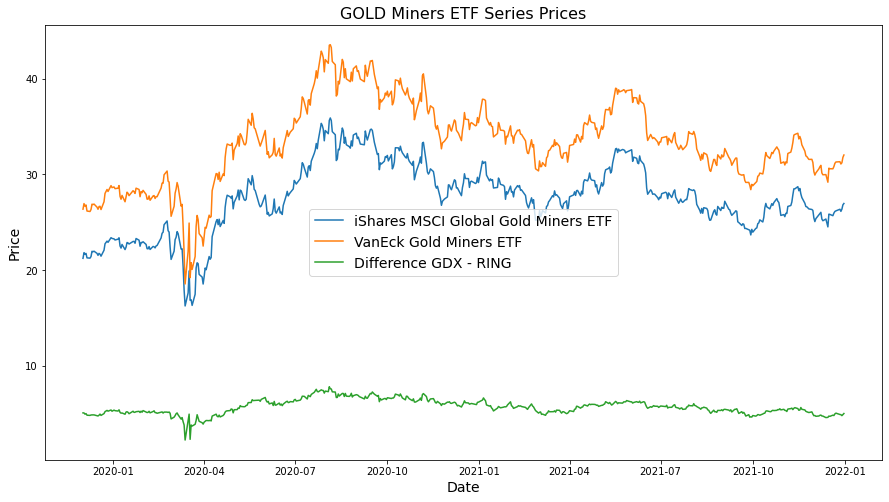

In [10]:
plt.plot(df.RINGadj_close, label = "iShares MSCI Global Gold Miners ETF")
plt.plot(df.GDXadj_close, label = "VanEck Gold Miners ETF" )
plt.plot(df.GDXadj_close - df.RINGadj_close, label = "Difference GDX - RING" )
plt.legend(fontsize = 14)
plt.xlabel('Date',fontsize = 14)
plt.ylabel('Price',fontsize = 14)
plt.title("GOLD Miners ETF Series Prices",fontsize = 16)
plt.show()

<b> Observation </b> The two price series almost entirely move synchronously for the two year time period. The difference between the two is therefore almost constant. There is a higher volatility only during March 2020 at the onset of Covid-19 crisis.

<b> Series Returns </b> We plot the return on the series to further capture the difference in the two series

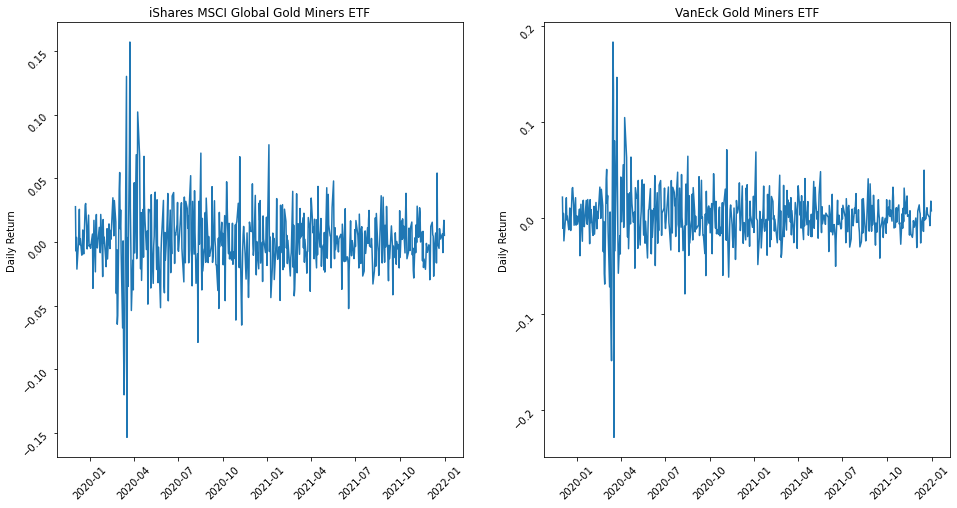

,Mean,Volatility,Sharpe Ratio,Skewness,min return,95% VaR,Excess Kurtosis
RINGRet,0.0097,0.0927,0.1051,0.1223,-0.1536,-0.0377,6.2838
GDXRet,0.0095,0.1006,0.0949,-0.3240,-0.2282,-0.0369,13.3162


In [11]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.plot(df['RINGRet'],label = "iShares MSCI Global Gold Miners ETF Returns")
ax1.set(title = "iShares MSCI Global Gold Miners ETF")
ax1.tick_params(labelrotation = 45)
ax1.set_ylabel("Daily Return")

ax2.plot(df['GDXRet'],label = "VanEck Gold Miners ETF Returns")
ax2.set(title="VanEck Gold Miners ETF")
ax2.tick_params(labelrotation = 45)
ax2.set_ylabel("Daily Return")

plt.show()
summaryStats(df[['RINGRet','GDXRet']])

<b>Observation:</b> From the plot, we observe the two series have very similar looking daily return distribution over the last two years. 'VanEck Gold Miners ETF' seems to be less volatile in the period after the shock in March 2020. However, the shock in March 2020 was of bigger magnitude.
Further, the series' risk and return measures are also quite close.

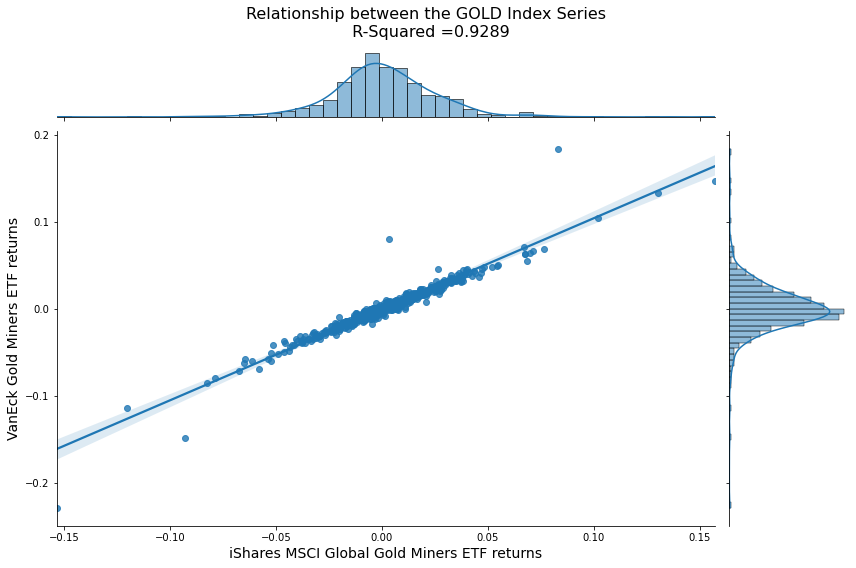

In [12]:
p = sns.jointplot(x = df['RINGRet'],y = df['GDXRet'],kind='reg')
p.fig.set_figwidth(12)
p.fig.set_figheight(8)
p.set_axis_labels('iShares MSCI Global Gold Miners ETF returns', 'VanEck Gold Miners ETF returns', fontsize=14)
p.fig.suptitle("Relationship between the GOLD Index Series \n R-Squared ="\
               +str(round(np.square(df['RINGRet'].corr(df['GDXRet'])),4)),fontsize=16)
p.fig.tight_layout()

<b> Observation:</b> We see that 'iShares MSCI Global Gold Miners ETF returns' series is closer to Normal distribution whereas  'VanEck Gold Miners ETF returns' series is more closely cenetered around the mean. <br>
Regressing 'VanEck Gold Miners ETF returns' on 'iShares MSCI Global Gold Miners ETF returns', we see an extremely well fitted line with just a handful outliers in two year daily trading positions.

## 4. Trading Strategies
Primarily, we will play with our parameters M, g, j and s to see which combination works well as a trading strategy. Ofcourse, this methodology has a look back bias as it would suggest using parameters that would have worked in the past but may look rouge in a well functioning strategy. We would then try filtering to a strategy which performs well without relying heavily on profiting from taking profitable positions at idesyncratic data points.
<br><br>
<b> Note: </b> Return on Capital is computed based on the assumption that capital consumed for each strategy is 2 * max($N_t$)/100 = 269,480.09 and is unannualized.


### Arbitrary starting strategy
We start of with an arbitrary strategy where we use 15 days of rolling mean returns with thresholds to enter trade at 0.05% spread and exit at 0.02%. These are arbitrary trial parameters to see the strategy in action.

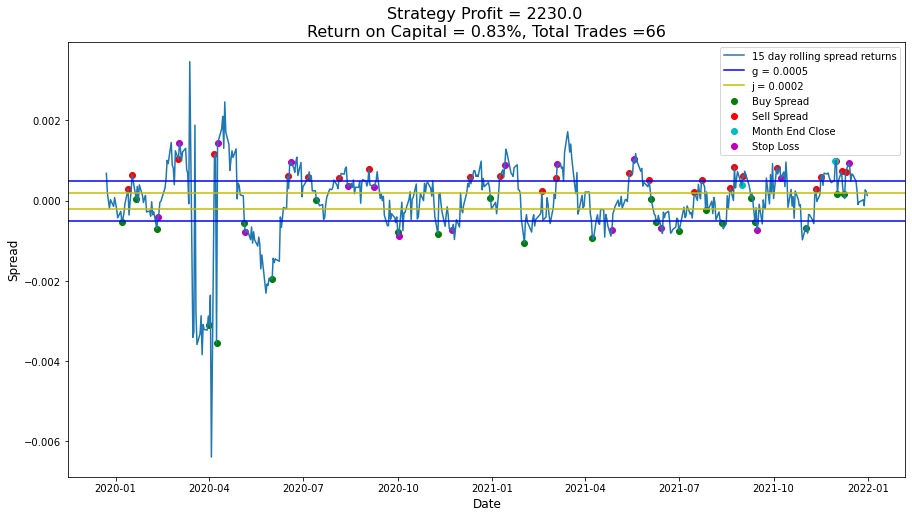

In [13]:
strategy = executeStrategy(M = 15, g = 0.0005, j = 0.0002, s = -0.0005)

<b> Observations: </b><br>
1. The strategy is barely profitable 
2. The strategy has too many stop loss thresholds hit which are capping the profitability in a big way
3. The return series had a volatile period in March 2020. <u> To bring our focus on the remaining time period, we would restrict the plot axis between the daily return thresholds of -0.0025 and +0.0025 </u>

<b> Since we know that the series is mean reverting in the long run, we could probably keep Stop loss limits relatively large and try profiting from there.

### Stop Loss Strategy
So we had a very narrow stop loss range in the previous strategy. We now try widening the stop loss to see how we could profit from it.

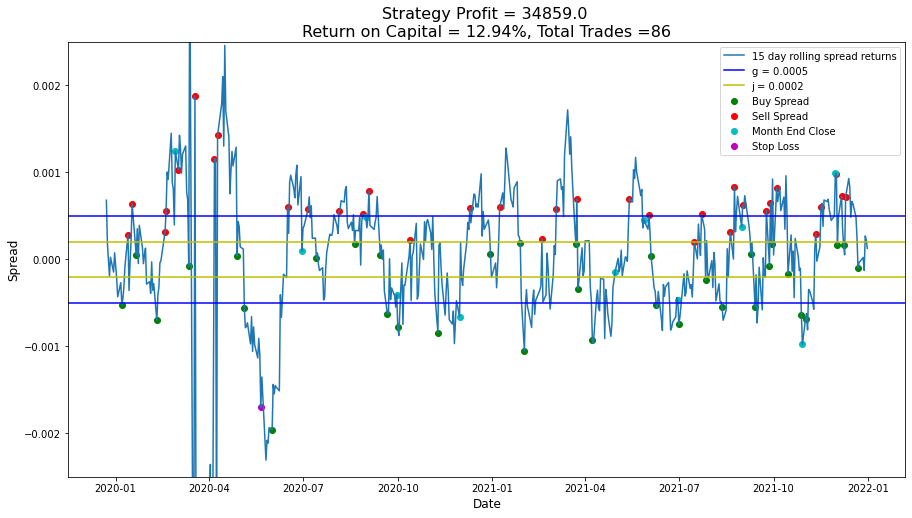

In [14]:
strategy = executeStrategy(M = 15, g = 0.0005, j = 0.0002, s = -0.01,plot=True,ylim=[-0.0025,0.0025])

<b>Observation:</b> While we still impose a fair stop loss limit, the profitability has greatly enhanced. <b> Thus, for such mean reverting series, we may thus bet heavily on the reversion to occur at some time in future and could allow leniency in Stop Loss Threshold. </b>

### Finding the best strategy parameters
To find the best trading strategy, we try different values of M (rolling window size), g (enterThreshold) and j (exitThreshold). Then we list the top 25 combinations of the trading strategy 


In [15]:
rollingWindowDays = [2,5,10,21]
enterThreshold = [0.0003,0.0005,0.0007,0.0010]
exitThrehold = [0,0.0001,0.0002,0.0003]

rocs = rocSummary(rollingWindowDays,enterThreshold,exitThrehold)

#### Best performing Trading Strategies

In [16]:
#Top 25 trading strategies by ROC
rocs.sort_values(by = ['Return on Capital'],ascending=False).head(25)

,Rolling Window,Enter Threshold,Exit Threshold,Return on Capital
Strategy #,,,,
1,2.0000,0.0003,0.0000,17.9008
2,2.0000,0.0003,0.0001,17.8970
5,2.0000,0.0005,0.0000,17.7571
6,2.0000,0.0005,0.0001,17.7493
16,2.0000,0.0010,0.0003,17.6768
3,2.0000,0.0003,0.0002,17.6175
14,2.0000,0.0010,0.0001,17.5528
13,2.0000,0.0010,0.0000,17.5386
10,2.0000,0.0007,0.0001,17.5163


<b> Observations: </b> From the 25 Trading strategies, we note that the best performing strategies (top 17) are executed over a two day rolling window period <br>
Let us try analyzing one the top strategy

Next, we see the <u> top 3 trading strategies for each of the window size

In [17]:
rocs.sort_values(by = ['Return on Capital'],ascending=False).groupby('Rolling Window').head(3)

,Rolling Window,Enter Threshold,Exit Threshold,Return on Capital
Strategy #,,,,
1,2.0000,0.0003,0.0000,17.9008
2,2.0000,0.0003,0.0001,17.8970
5,2.0000,0.0005,0.0000,17.7571
20,5.0000,0.0003,0.0003,15.4032
24,5.0000,0.0005,0.0003,15.1080
28,5.0000,0.0007,0.0003,14.2287
46,10.0000,0.0010,0.0001,12.2083
47,10.0000,0.0010,0.0002,12.1813
48,10.0000,0.0010,0.0003,11.9276


We see that the shorter rolling window strategies outperform longer rolling window strategies. Further, the top-performing strategies typically use closely related values of g and j. We may need to manually filter these values to obtain realistic trading ideas.

### Evaluating some of the best performing strategies
#### 2 day Rolling Window average strategies
We first try the best performing strategy. This is based on two day rolling average and keeps the thresholds fairly low with g = 0.0003 and j = 0.

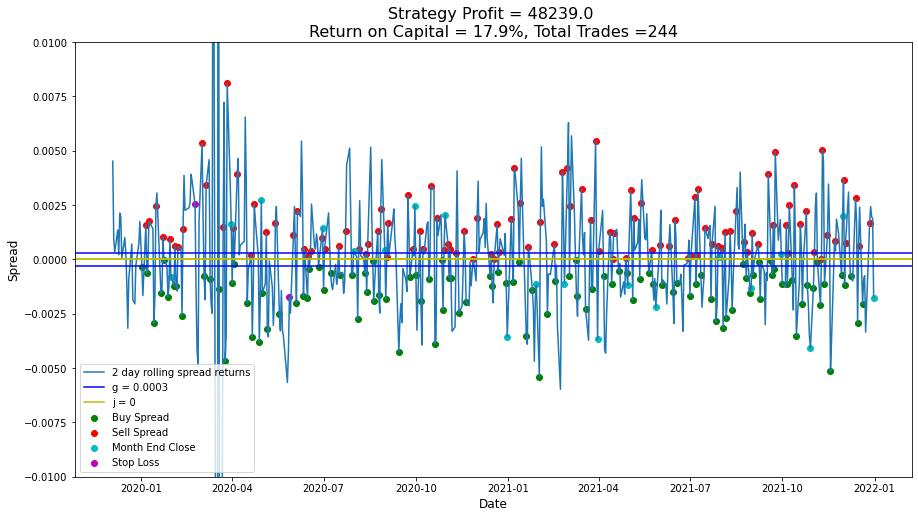

In [18]:
strategy = executeStrategy(M = 2, g = 0.0003, j = 0, s = -0.01,plot=True,ylim=[-0.01,0.01])

<b> Observation: </b> While the strategy has impressive returns, we note that it is characterized by <u>too frequent trading  </u>. In reality, such a strategy would have very high trading costs.

Next, we try keeping the intermediate thresholds of g = 0.002 and j = 0.0005

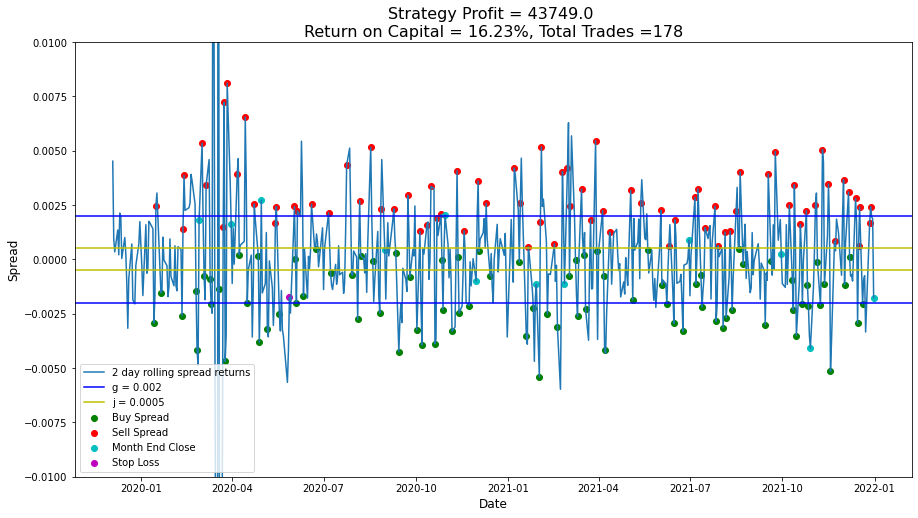

In [19]:
strategy = executeStrategy(M = 2, g = 0.002, j = 0.0005, s = -0.01,plot=True,ylim=[-0.01,0.01])

<b> Observation: </b>While the number of trades have reduced significantly, there are still way <u> too many trades </u> to be executed. This is because this strategy, based on just two rolling mean window is bound to be more volatile. 

To further reduce the number of trades, we try very high entering and exit thresholds for the two day rolling average strategy

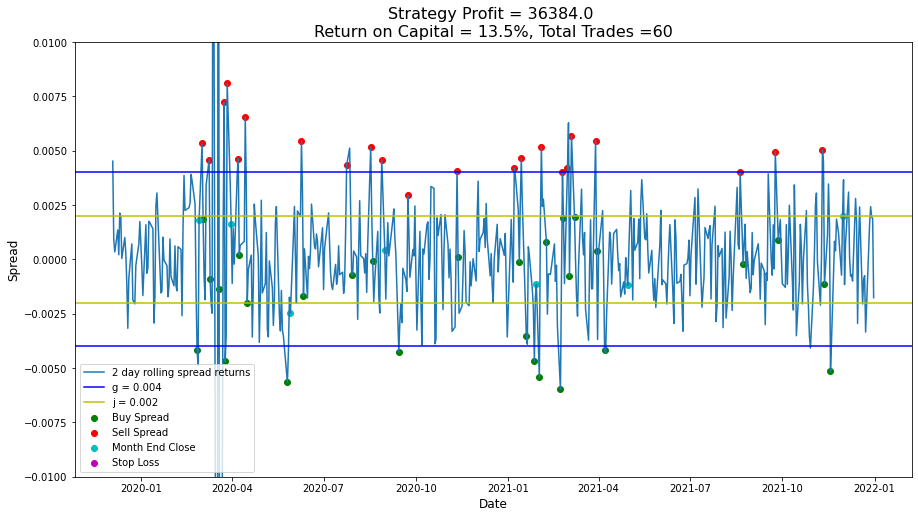

In [20]:
strategy = executeStrategy(M = 2, g = 0.004, j = 0.002, s = -0.01,plot=True,ylim=[-0.01,0.01])

<b> Observation: </b> Now, while the number of trades have reduced, the Return on Capital has also declined significantly. We could still <u> consider this as a plausable strategy as it could give decent returns even when including the trading costs </u>. At the same time, the returns are less than our top-performing strategies with window size average of 5 days which we shall analyze next. 

We define a dataframe to keep track of plausable strategies

In [21]:
plausableStrategies = pd.DataFrame(columns=\
                                 ['Rolling Window', 'Enter Threshold','Exit Threshold','Stop Loss','Return on Capital'])
plausableStrategies.index.name = 'Strategy #'
plausableStrategies.loc['2_Day_Strategy'] =  [2, 0.004, 0.002,-0.01,strategy[1]]

#### 5 day Rolling Window average strategies

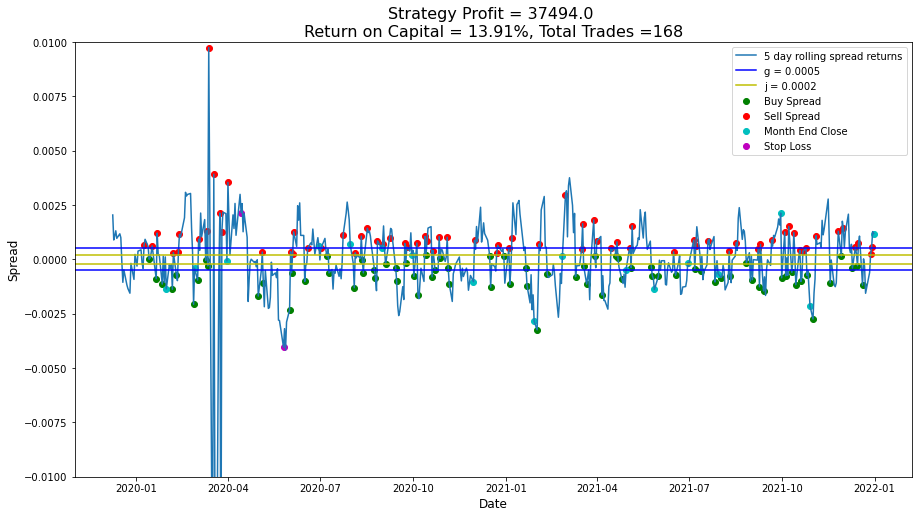

In [22]:
strategy = executeStrategy(M = 5, g = 0.0005, j = 0.0002, s = -0.01,plot=True,ylim=[-0.01,0.01])

<b> Observations: </b> The number of trades is still very large even at 5 day rolling window. To reduce the number of trades, let us try increasing the trade thresholds.

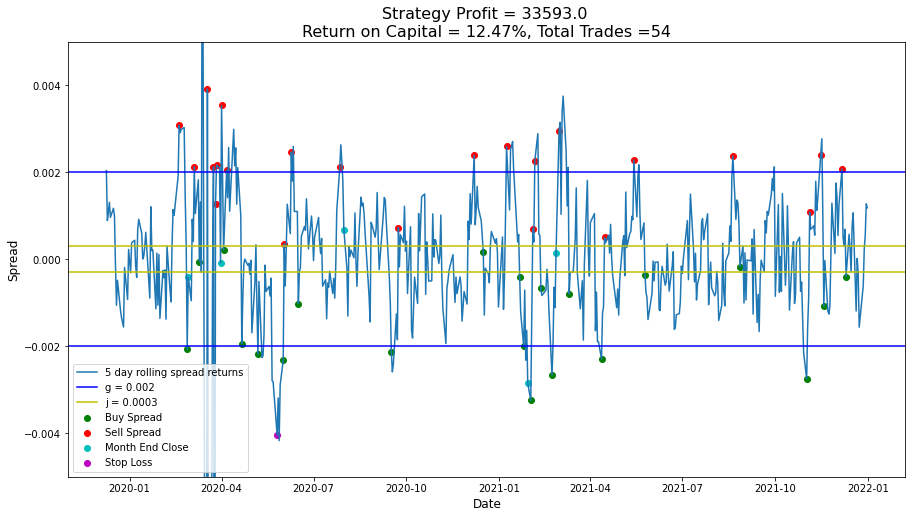

In [23]:
strategy = executeStrategy(M = 5, g = 0.002, j = 0.0003, s = -0.01,plot=True,ylim=[-0.005,0.005])

<b> Observation </b> After controlling the number of trades, the 5 day rolling window, is giving fair returns. This may be considered as a <u> plausable trading strategy </u>.

In [24]:
plausableStrategies.loc['5_Day_Strategy'] =  [5, 0.002, 0.0003,-0.01,strategy[1]]

#### 10 day Rolling Window average strategies

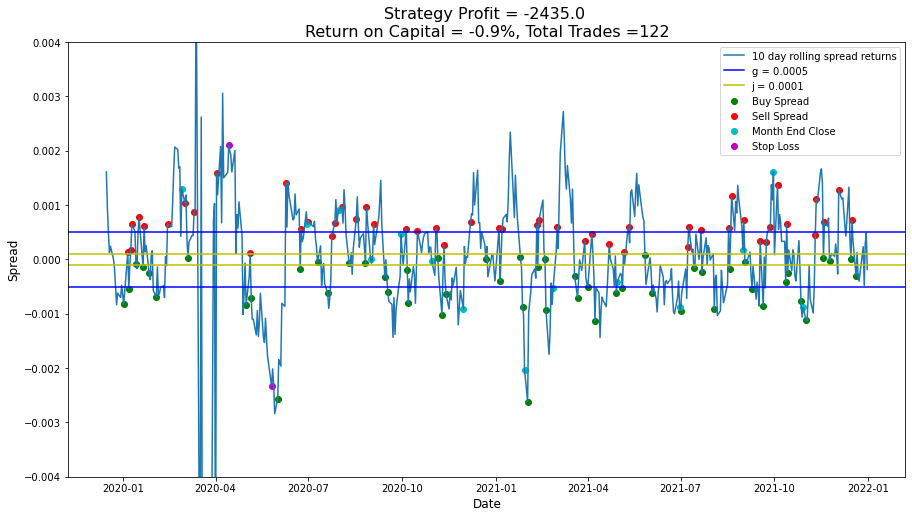

In [25]:
strategy = executeStrategy(M = 10, g = 0.0005, j = 0.0001, s = -0.01,plot=True,ylim=[-0.004,0.004])

<b> Observation: </b> Over 10 day rolling window, very narrow bands do no give a good strategy as we observe a negative return with large number of trades.

To limit the number of trades, we widen the spreads fot the 10 day window

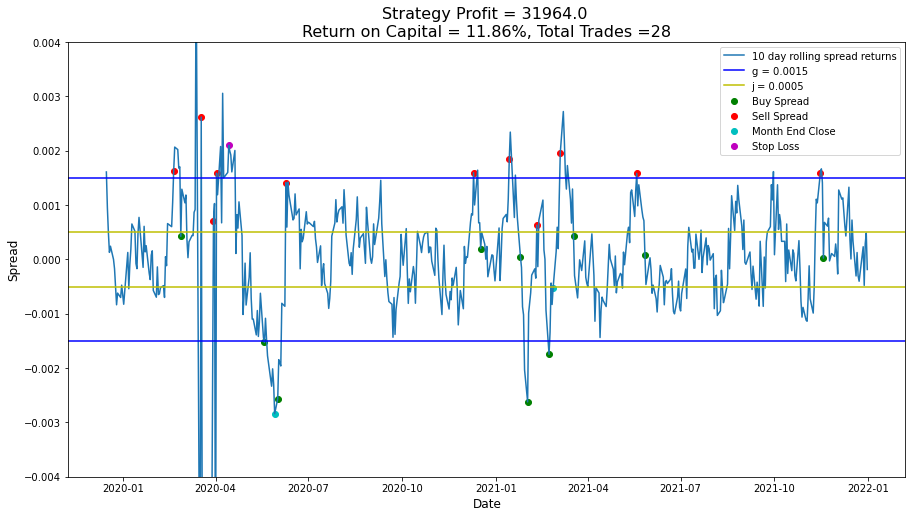

In [26]:
strategy = executeStrategy(M = 10, g = 0.0015, j = 0.0005, s = -0.01,plot=True,ylim=[-0.004,0.004])

<b> Observations: </b> With a very wide window size, we could limit the number of trades drastically and still get a fair return. We should consider this as a plausable trading strategy. 

In [27]:
plausableStrategies.loc['10_Day_Strategy'] =  [10, 0.0015, 0.0005,-0.01,strategy[1]]

Finally, we try longer rolling window size of 21 days.

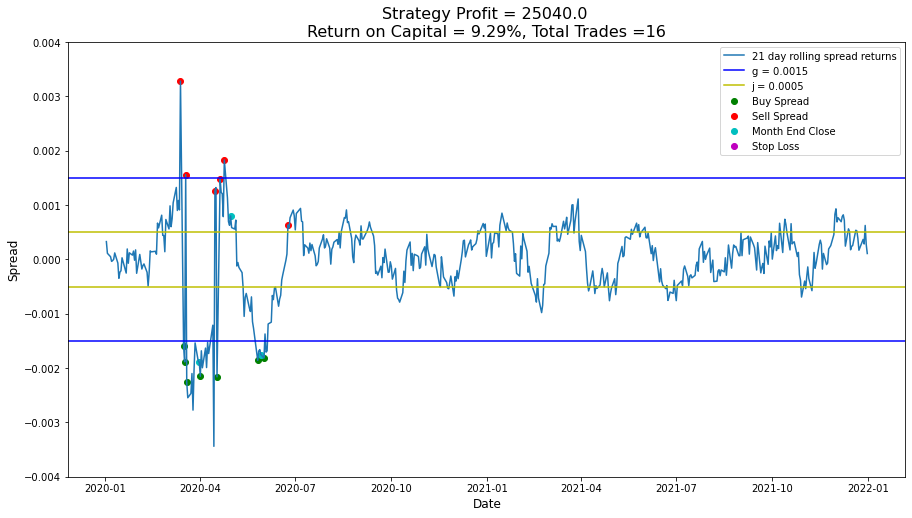

In [28]:
#with wide trading spreads
strategy = executeStrategy(M = 21, g = 0.0015, j = 0.0005, s = -0.01,plot=True,ylim=[-0.004,0.004])

<b> Observation: </b> With wide trading spreads, we only get to trade during the very volatile period during the onset of Covid-19 crisis. This strategy has very limited investing opportunity and may not be plausable.

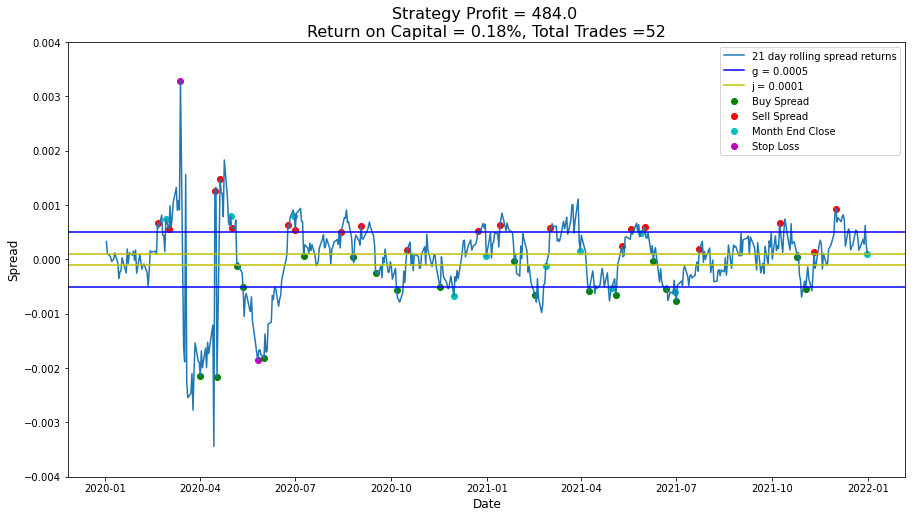

In [29]:
#with narrow trading spreads
strategy = executeStrategy(M = 21, g = 0.0005, j = 0.0001, s = -0.01,plot=True,ylim=[-0.004,0.004])

<b> Observation: </b> With narrow trading spreads, the profitability is lower. This is because our series are highly correlated and tend to mean revert in much shorter time windows. 
<b> Thus we do not see a good trading strategy for 21 day rolling window period

### Conclusions: 
- After limiting the number of trades to around 70 (over two  year trading period), we get a ROC of around 12-13% in each of the window size selected (2 days, 5 days and 10 days)
- 2 Day rolling window is of course very volatile and thus requires the thresholds at very high levels. This is still profitable as you could take high returns from mean reversions
- 10 Day rolling window is less volatile and you could profit with lower thresholds.
- If the trading costs are very low, the returns could be enhanced drastically (to around 17%) by increasing the number of trades by going for a shorter window size and (2-day rolling window with narrow trading bands could yield around 18% ROC).
- If the trading costs are very high, we could use longer window sizes and high thresholds to get decent returns (around 12% ROC with 10 day rolling window)
- Strategies with longer trading windows (around 21 days) have poor returns. This is because these series generally tend to mean revert over shorter time durations

<u><b> We therefore consder the following trading strategies to be good:

In [30]:
plausableStrategies

,Rolling Window,Enter Threshold,Exit Threshold,Stop Loss,Return on Capital
Strategy #,,,,,
2_Day_Strategy,2.0000,0.0040,0.0020,-0.0100,13.5014
5_Day_Strategy,5.0000,0.0020,0.0003,-0.0100,12.4657
10_Day_Strategy,10.0000,0.0015,0.0005,-0.0100,11.8614


## 5. Comparing with Fama-French style factors

Now, we compare the returns on the three shortlisted trading strategies to the Fama-French style factors. We begin by importing the Fama-French 3-factor returns and computing the returns (on Cumulative P&L) of our trading strategies. 

In [31]:
#pdr.famafrench.get_available_datasets()
ff_rtn = pdr.DataReader("F-F_Research_Data_Factors_daily","famafrench",'2019-12-02')[0]/100
ff_rtn.tail()

,Mkt-RF,SMB,HML,RF
Date,,,,
2021-12-27,0.0122,-0.0009,0.0028,0.0000
2021-12-28,-0.0027,-0.0059,0.0080,0.0000
2021-12-29,0.0006,-0.0006,0.0015,0.0000
2021-12-30,-0.0015,0.0010,-0.0038,0.0000
2021-12-31,-0.0031,0.0006,0.0053,0.0000


In [32]:
strategyReturn = ff_rtn.copy()

In [33]:
for p in plausableStrategies.index:
    
    r,g,j,s = (plausableStrategies.loc[p]['Rolling Window'], plausableStrategies.loc[p]['Enter Threshold']\
               ,plausableStrategies.loc[p]['Exit Threshold'], plausableStrategies.loc[p]['Stop Loss'])
    d,roc = executeStrategy(int(r),g,j,s,plot=False)
    
    
    strategyReturn[p] = d.cumPnL / d.cumPnL.shift() - 1
strategyReturn = strategyReturn['2020-1':]

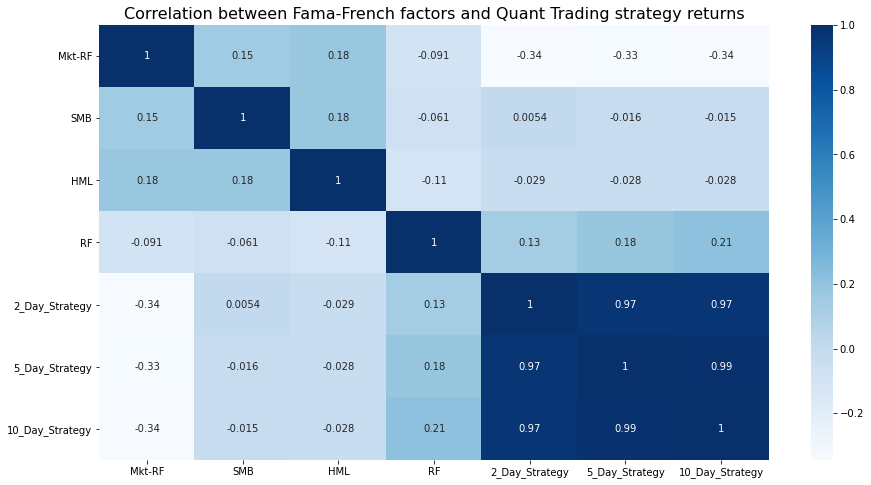

In [34]:
sns.heatmap(strategyReturn.corr(),annot=True,cmap='Blues')
plt.title("Correlation between Fama-French factors and Quant Trading strategy returns", fontsize = 16)
plt.show()

<b> Observation: </b> We note that the Gold Spread strategy return has  low correlation with the Fama-French style factor. This is expected as both the construction and dynamics of the Gold ETF Spread strategy is very different from the Fama French factors. We do observe a large negative correlation with the Market Risk premium factor. <b> Thus this makes such a mean reverting strategy ideal for diversifying market and other Fama French related exposures. </b><br>

Further, we observe that the three plausable strategies considered are highly correlated to each other. Thus, for the remaining analysis, we shall only consider 5 Day Strategy for comparing with the Fama French Factors.

### Comparision over time - Quarterly time periods 

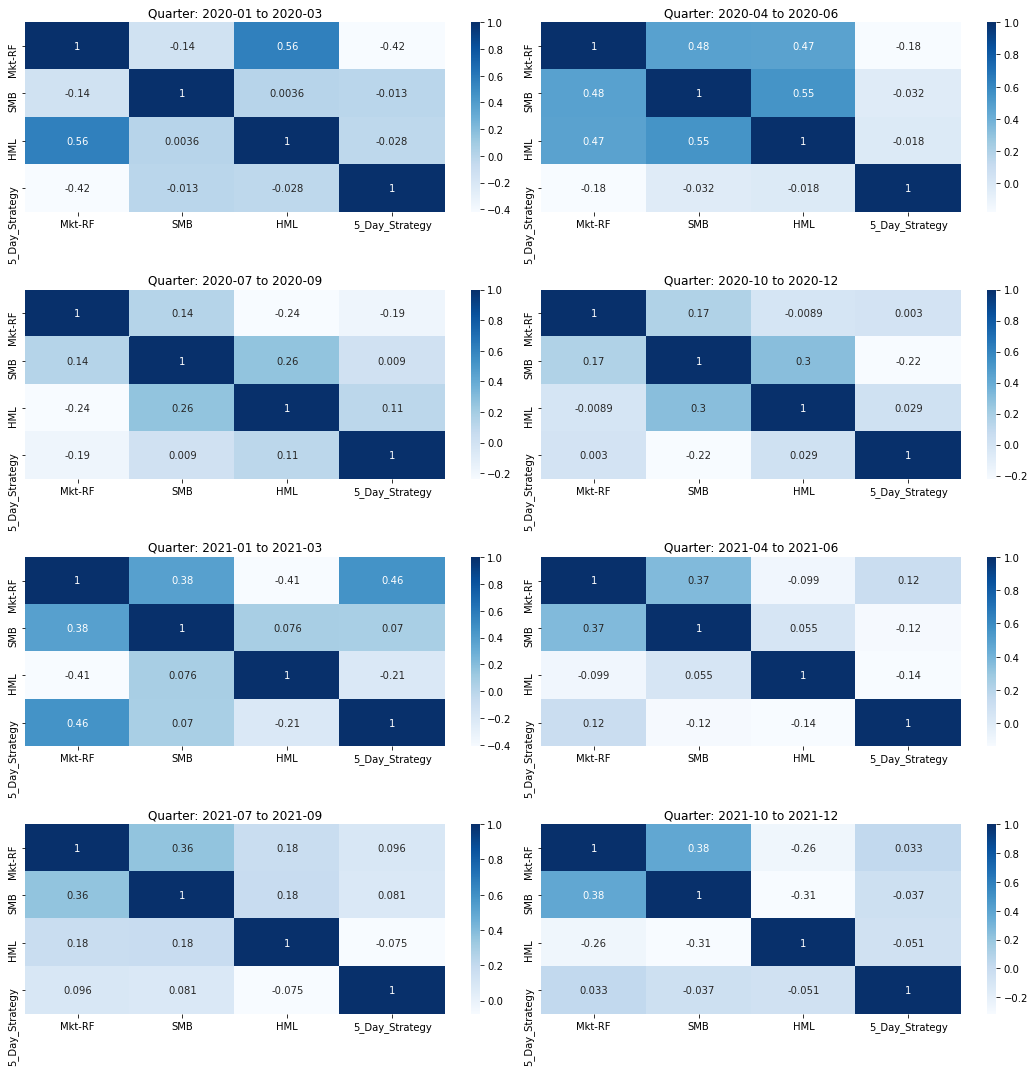

In [35]:
strategyReturnSub = strategyReturn[['Mkt-RF','SMB','HML','5_Day_Strategy']]
fig, ax = plt.subplots(4, 2, figsize=(15, 15))
periods = [('2020-01','2020-03'),('2020-04','2020-06'),('2020-07','2020-09'),('2020-10','2020-12'),\
          ('2021-01','2021-03'),('2021-04','2021-06'),('2021-07','2021-09'),('2021-10','2021-12')]

for i in range(8):
    idx = (i//2,i%2)
    sns.heatmap(strategyReturnSub[periods[i][0]:periods[i][1]].corr(),ax = ax[idx],annot=True,cmap="Blues")
    ax[idx].set(title = "Quarter: "+periods[i][0]+' to ' +periods[i][1])
    fig.tight_layout()

<b> Observations: </b> <br>
<u> Jan to Mar 2020</u>: The period from Jan to Mar 2020 were volatile periods for the global markets. <b> We observe a very high negative correlation of -0.42 during this period between Gold Spread return series and the Market Risk Factor. </b> This may be because during highly volatile periods, the trading strategies can behave differntly than normal times in a similar way the market moves differently than normal times. In this case, we had a strong market correction which is negatively correlated to the excellent returns we generate on mean reversion strategy as the spreads are mispriced for longer time periods.<br>
Notably, we could have expected a higher correlation between say HML and spread reversion strategies during this period. This is because pricing anomlies would have tended to stay for longer during these periods. However, we do not observe such a behavior here. <br>

Interestingly, we observe a high positive correlation of 0.46 between Market Risk premium and Gold ETF spread reversion strategy return during Jan to Mar 2021.


## 6. Conclusion

- Based on the type of constraints we face while trading, such as trading costs and trading frequencies, we could classify trading strategies and the parameters that could be most suitable for our use
- For a highly correlated and quickly mean reverting pair of ETFs we should use a short rolling window of returns (up to about 5 days) to capture the profitability in the spread.
- To reduce the number of trades, we could keep the trade entering thresholds higher
- If there is a high confidence on mean reversion, as it was in this case, we could keep the stop loss limits more leniently and profit from it
- In general, during periodes of lower volatility, spread reversion strategies are very less correlated with Market and other Fama-French style factors. This makes such strategies ideal for diversification
- During periods of very high market volatility, such as during March 2020, such strategies showed high negative correlation to the market risk premium